In [1]:
import pandas as pd
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(suppress=True)

In [2]:
def sim_bets(real_bets, simulation_num):
    """
    функция создает матрицу с симуляцией исходов, содержащую числа от 0 до 1,
    где кол-во строк = кол-ву результатов в real_bets а кол-во столбцов = кол-ву симуляций
    real_bets - матрица с реальной историей ставок
    simulation_num - кол-во симуляций
    """    
    sim_bets = np.random.rand(simulation_num, real_bets.shape[0])
    
    # вместо исходов запишем его результат
    for j in range(real_bets.shape[0]):
        for i in range(sim_bets.shape[0]):
            # если в симуляции ставка проиграла - записывает -amount данной ставки
            if sim_bets[i][j] >= real_bets[j][1]:
                sim_bets[i][j] = -real_bets[j][0]
            # если в симуляции ставка выиграла, запишем маржу игрока    
            else:
                sim_bets[i][j] = (1/real_bets[j][1] - 1)*(real_bets[j][0])
                
    # по каждой симуляции считаем profit, получаем список размером = кол-ву симуляций
    sim_profit_list = sim_bets.sum(axis=1)
    
    return sim_profit_list

In [3]:
def get_margin_prob(real_margin, sim_profit_list):
    """ 
    Функция считает вероятность, что маржинальность на графике окажется >= заданной
    и рисует график
    """
    # получаем координаты KDE line
    ax = sns.distplot(sim_profit_list)
    xdata, ydata = ax.get_lines()[0].get_data()

    # Ищем ближайшую точку на графике
    idx = (np.abs(xdata-real_margin)).argmin()
    # Интерполяция для лучшей оценки
    p = np.interp(real_margin,xdata[idx:idx+2],ydata[idx:idx+2])
    #print('Point on PDF for X = {} is: {}'.format(real_margin,p))

    #Ищем вероятность мужду заданной маржинальностью и максимумом
    ecart = max(sim_profit_list)-real_margin
    idx = (np.abs(xdata-real_margin)).argmin()
    idx_ = (np.abs(xdata-(real_margin+ecart))).argmin()

    cdf = scipy.integrate.cumtrapz(ydata, xdata, dx=1, initial=0)
    pr = cdf[idx_] - cdf[idx]  
    #print('\nProbability of margin >={:.2f} is {:.2f}% after {} simulations'.format(real_margin,pr*100,len(sim_profit_list)))

    ax.fill_between(xdata, ydata, where=(xdata >= real_margin) , 
                    interpolate=True, color='#EF9A9A')

    return ax

In [4]:
# читаем тестовые данные и формируем нужные столбцы

#тестовые данные дэвида
df = pd.read_csv('seer_david_example.txt', sep='\t')

# подготовка нужных столбцов
df['p_win'] = 1/df['rate']
df['profit'] = df['payoff']-df['amount']
df.head()

,event_name,outcome,status,id,rate,amount,payoff,result,bet_date,bet_hour,created_at,sport_name,user_id,market_name,live,p_win,profit
0,Сычуань v Шэньчжэнь Авиаторс,Больше 81.5,NaN,361802301,1.90,5000,0,Loss,01.07.2020,7,01.07.2020 7:47,Basketball,405472,Basketball,PM,0.526316,-5000
1,Сычуань v Шэньчжэнь Авиаторс,Больше 46.5,NaN,361804998,1.85,5000,9250,Win,01.07.2020,7,2020-07-01 07:59,Basketball,405472,Basketball,PM,0.540541,4250
2,Таранаки v Отаго Наггетс,Меньше 50.5,NaN,361816536,1.85,3250,6013,Win,01.07.2020,8,2020-07-01 08:41,Basketball,405472,Basketball,PM,0.540541,2763
3,Таранаки v Отаго Наггетс,Меньше 87.5,NaN,361825541,1.85,2480,4588,Win,01.07.2020,9,2020-07-01 09:08,Basketball,405472,Basketball,PM,0.540541,2108
4,Шанхай Шаркс v Синьцзян Флаинг Тайгерс,Больше 45.5,NaN,361857380,1.76,2000,0,Loss,01.07.2020,10,2020-07-01 10:36,Basketball,405472,Basketball,PM,0.568182,-2000


In [5]:
# на самом деле нужно 3 столбца
# amount - сумма ставки
# p_win - вероятностность события
# profit - маржа игрока по отдельной ставке (-amount в случае проигрыша, payoff-amount в случае выигрыша)

# формируем массив из этих данных
real_bets = df[['amount','p_win','profit']].to_numpy()

print('Ставок у пользователя {}'.format(len(real_bets)))

Ставок у пользователя 39


In [6]:
%%time
# считаем profit игрока на реальных ставках
real_profit = real_bets.sum(axis=0)[2]
real_profit_prcnt = real_profit/real_bets.sum(axis=0)[0] 

# делаем симуляцию, возвращаем массив с профитами
simulation_num = 10000
sim_profit_list = sim_bets(real_bets, simulation_num)

# считаем кол-во симуляций, где profit получился больше реального
chance_outcomes = sum(i > real_profit for i in sim_profit_list)
chance_percent = chance_outcomes / simulation_num
    
# считаем кол-во сумуляций, где profit получился ниже реального
skill_outcomes = len(sim_profit_list) - chance_outcomes
skill_percent = skill_outcomes / simulation_num

print('Игрок сделал {} ставок, маржа {:.2f}({:.2f}%)'.format(len(real_bets), real_profit, 
                                                   real_profit_prcnt*100))
print('Вероятность такой или большей маржи = {:.2f}% после {} симуляций'.
      format(chance_percent*100, simulation_num))
print('\nВремя расчета:')

Игрок сделал 39 ставок, маржа 7698.00(8.21%)
Вероятность такой или большей маржи = 31.15% после 10000 симуляций

Время расчета:
Wall time: 622 ms


C:\Users\Insar\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

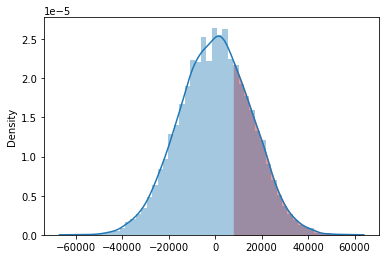

In [7]:
# нарисуем
get_margin_prob(real_profit, sim_profit_list)